In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np

import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision import transforms
from IPython.display import clear_output
from tqdm import tqdm

from sklearn.datasets import make_swiss_roll

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def weak_sq_cost(X, T_XZ, gamma):
    """
    Input
    --------
    X : tensor, shape (bs, dim) or (bs, n_ch, w, h)
    T_XZ : tensor, shape (bs, z_size, dim) or (bs, z_size, n_ch, w, h)
    gamma : float

    Output
    --------
    cost : tensor, shape ()
    """
    X = X.flatten(start_dim=1)
    T_XZ = T_XZ.flatten(start_dim=2)
    z_size = T_XZ.size(1)
    
    l2 = (X[:,None] - T_XZ).square().sum(dim=2).mean()
    var = T_XZ.var(dim=1).sum(dim=1).mean()
    return l2 - 0.5 * gamma * var

COST = weak_sq_cost

In [3]:
def weak_kernel_cost(X, T_XZ, gamma):
    """
    Input
    --------
    X : tensor, shape (bs, dim) or (bs, n_ch, w, h)
    T_XZ : tensor, shape (bs, z_size, dim) or (bs, z_size, n_ch, w, h)
    gamma : float

    Output
    --------
    cost : tensor, shape ()
    """
    X = X.flatten(start_dim=1)
    T_XZ = T_XZ.flatten(start_dim=2)
    z_size = T_XZ.size(1)
    
    l2_dist = (X[:,None] - T_XZ).norm(dim=2).mean()
    kvar = .5 * torch.cdist(T_XZ, T_XZ).mean() * z_size / (z_size -1)
    return l2_dist - 0.5 * gamma * kvar

COST = weak_kernel_cost

In [4]:
BATCH_SIZE = 16


TRANSFORM = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

sigma_dr = 0.2
def add_random_noise(im):
    return im + sigma_dr * torch.randn_like(im)

TRANSFORM_DR = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(16, interpolation =transforms.InterpolationMode.BICUBIC),
    add_random_noise,
    transforms.Resize(32, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist_train = datasets.MNIST(root='../', train=True, download=True, transform=TRANSFORM)
mnist_train_dr = datasets.MNIST(root='../', train=True, download=True, transform=TRANSFORM_DR)
idx = np.array(range(len(mnist_train)))
mnist_2 = torch.utils.data.Subset(mnist_train, idx[mnist_train.targets==2])
mnist_2_dr = torch.utils.data.Subset(mnist_train_dr, idx[mnist_train.targets==2])
mnist_2_loader = torch.utils.data.DataLoader(mnist_2, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
mnist_2_dr_loader = torch.utils.data.DataLoader(mnist_2_dr, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Load test datasets
mnist_test = datasets.MNIST(root='../', train=False, download=True, transform=TRANSFORM)
mnist_test_dr = datasets.MNIST(root='../', train=False, download=True, transform=TRANSFORM_DR)
idx = np.array(range(len(mnist_test)))
mnist_2_test = torch.utils.data.Subset(mnist_test, idx[mnist_test.targets==2])
mnist_2_test_dr = torch.utils.data.Subset(mnist_test_dr, idx[mnist_test.targets==2])
mnist_2_test_loader = torch.utils.data.DataLoader(mnist_2_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
mnist_2_test_dr_loader = torch.utils.data.DataLoader(mnist_2_test_dr, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# We pick a few samples from them for the qualitative analysis
Y_test_fixed = next(iter(mnist_2_test_loader))[0]
X_test_fixed = next(iter(mnist_2_test_dr_loader))[0]
Z_test_fixed = torch.randn(BATCH_SIZE, 4, 1, 32, 32)
with torch.no_grad():
    XZ_test_fixed = torch.cat([X_test_fixed[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)

/users/eleves-a/2020/david.heurtel-depeiges/Desktop/ALTeGraD23_Data_Challenge/venv/lib64/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
iter_mnist_2, iter_mnist_dr_2 = iter(mnist_2_loader), iter(mnist_2_dr_loader)

def sample_mnist_2():
    global iter_mnist_2, mnist_2_loader
    try:
        return next(iter_mnist_2)[0]
    except StopIteration:
        iter_mnist_2 = iter(mnist_2_loader)
        return next(iter_mnist_2)[0]

def sample_mnist_2_dr():
    global iter_mnist_dr_2, mnist_2_dr_loader
    try:
        return next(iter_mnist_dr_2)[0]
    except StopIteration:
        iter_mnist_dr_2 = iter(mnist_2_dr_loader)
        return next(iter_mnist_dr_2)[0]

Random (unpaired) images from MNIST-2 (first row) and MNIST-2 Down-Sampled (second row)


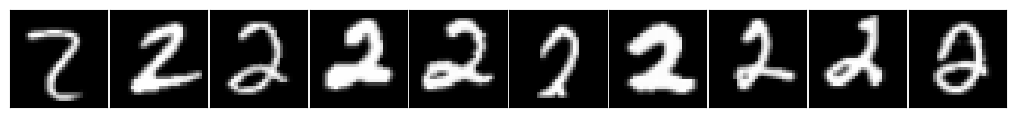

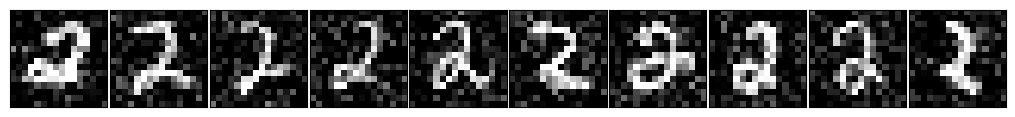

In [6]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0), cmap='gray')
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

print('Random (unpaired) images from MNIST-2 (first row) and MNIST-2 Down-Sampled (second row)')
plot_images(sample_mnist_2())
plot_images(sample_mnist_2_dr())

In [7]:
T = nn.Sequential(
    nn.Conv2d(1+1, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 1, kernel_size=5, padding=2),
).to(DEVICE)

f = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.AvgPool2d(2), #  128 x 8 x 8
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.AvgPool2d(2), #  256 x 4 x 4
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.AvgPool2d(2), #  512 x 2 x 2
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(True),
    nn.AvgPool2d(2), #  512 x 1 x 1
    nn.Conv2d(128, 1, kernel_size=1, padding=0),
    nn.Flatten(1),
).to(DEVICE)

T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 2058369
f params: 970497


/tmp/ipykernel_584435/669540171.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


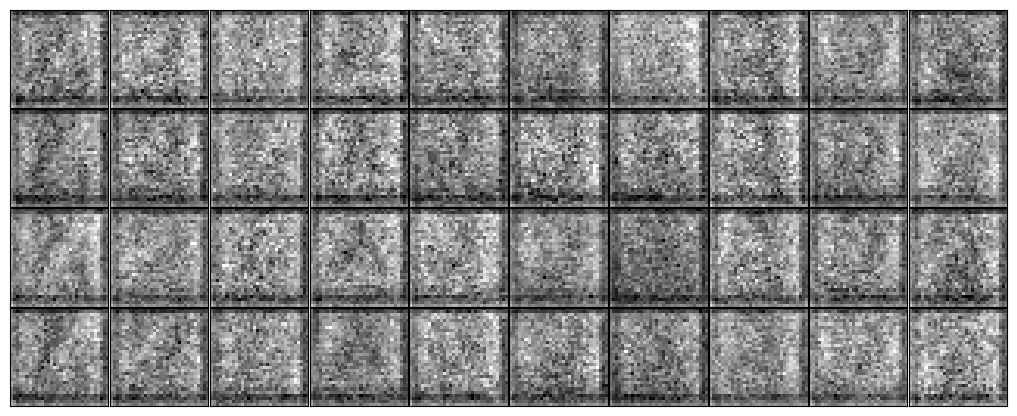

In [8]:
def plot_many_images(multibatch):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4), dpi=100)
    for i in range(10):
        for j in range(4):
            axes[j, i].imshow(multibatch[i, j].mul(0.5).add(0.5).clip(0,1).permute((1,2,0)), cmap='gray')
            axes[j, i].set_xticks([]); axes[j, i].set_yticks([])
    fig.tight_layout(pad=0.1)

with torch.no_grad():
    T_XZ_test_fixed = T(
        torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(1,32,32,BATCH_SIZE,4).permute(3,4,0,1,2).to('cpu')
plot_many_images(T_XZ_test_fixed)

In [9]:
COST = weak_sq_cost #weak_kernel_cost 

# Other parameters
T_ITERS = 10
MAX_STEPS = 3000 + 1
Z_SIZE = 4
GAMMA = 0 #0.5, 1

Step 500
GAMMA 0
Mnist-2 images X, mapped images T(X, Z), unpaired Mnist-3 images Y


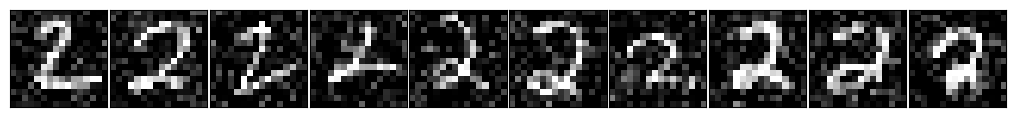

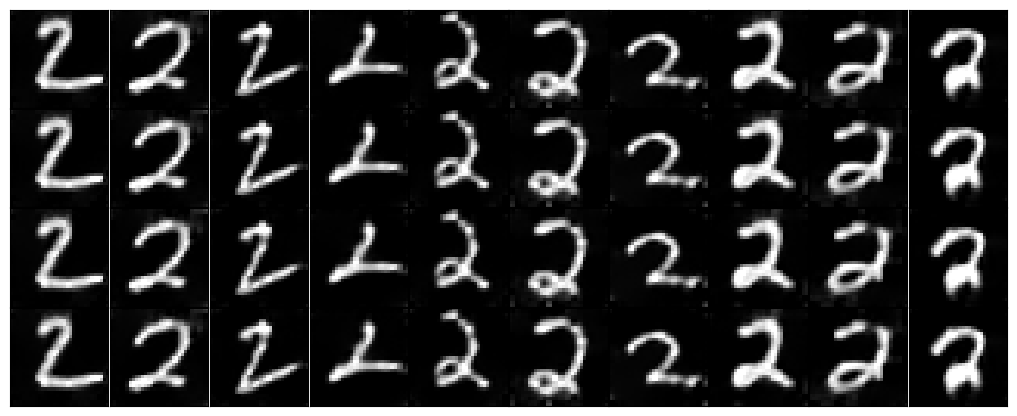

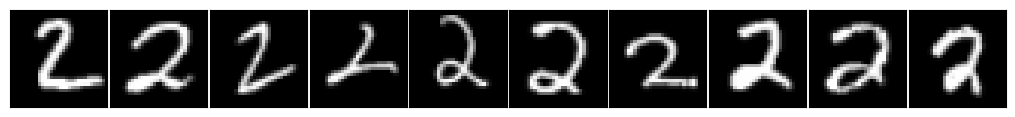

 20%|█▉        | 587/3001 [03:42<14:45,  2.73it/s]

In [10]:
# auxiliary functions

def hide_z(batch):
    "Converts batch B x Z x C x H x W -> BZ x C x H x W"
    return batch.reshape(batch.shape[0]*batch.shape[1], *batch.shape[2:])

def restore_z(batch, batch_size):
    "Converts batch BZ x C x H x W -> B x Z x C x H x W"
    return batch.reshape(batch_size, -1, *batch.shape[1:])


# NOT algorithm
for step in tqdm(range(MAX_STEPS)):
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        # Sample X, Z
        X = sample_mnist_2_dr().to(DEVICE) # (bs, 3, 16, 16)
        Z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 32, 32, device=DEVICE)  # (bs, z_size, 1, 16, 16)

        # Get T_XZ
        XZ = torch.cat([X[:,None].repeat(1,Z_SIZE,1,1,1), Z], dim=2) # (bs, z_size, 1+1, 32, 32)
        T_XZ = restore_z(T(hide_z(XZ)), BATCH_SIZE) # (bs, z_size, 1, 32, 32)

        # Compute the loss for T
        T_loss = COST(X, T_XZ, GAMMA).mean() - f(hide_z(T_XZ)).mean()

        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    # Sample X, Y, Z
    X = sample_mnist_2_dr().to(DEVICE) # (bs, 3, 16, 16)
    Z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 32, 32, device=DEVICE)  # (bs, z_size, 1, 16, 16)
    Y = sample_mnist_2().to(DEVICE) # (bs, 3, 16, 16)
    
    # Get T_XZ
    XZ = torch.cat([X[:,None].repeat(1,Z_SIZE,1,1,1), Z], dim=2) # (bs, z_size, 3+1, 16, 16)
    T_XZ = restore_z(T(hide_z(XZ)), BATCH_SIZE) # (bs, z_size, 3, 16, 16)

    # Compute the loss for f
    f_loss = - f(Y).mean() + f(hide_z(T_XZ)).mean()
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 100 == 0:
        clear_output(wait=True)
        print("Step", step)
        print("GAMMA", GAMMA)

        # The code for plotting the results
        with torch.no_grad():
            T_XZ_test_fixed = T(
                torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
            ).permute(1,2,3,0).reshape(1,32,32,BATCH_SIZE,Z_SIZE).permute(3,4,0,1,2).to('cpu')
        print('Mnist-2 down sampled images X, mapped images T(X, Z), corresponding Mnist-2 images Y')
        plot_images(X_test_fixed)
        plot_many_images(T_XZ_test_fixed)
        plot_images(Y_test_fixed)
        plt.show()

0
1


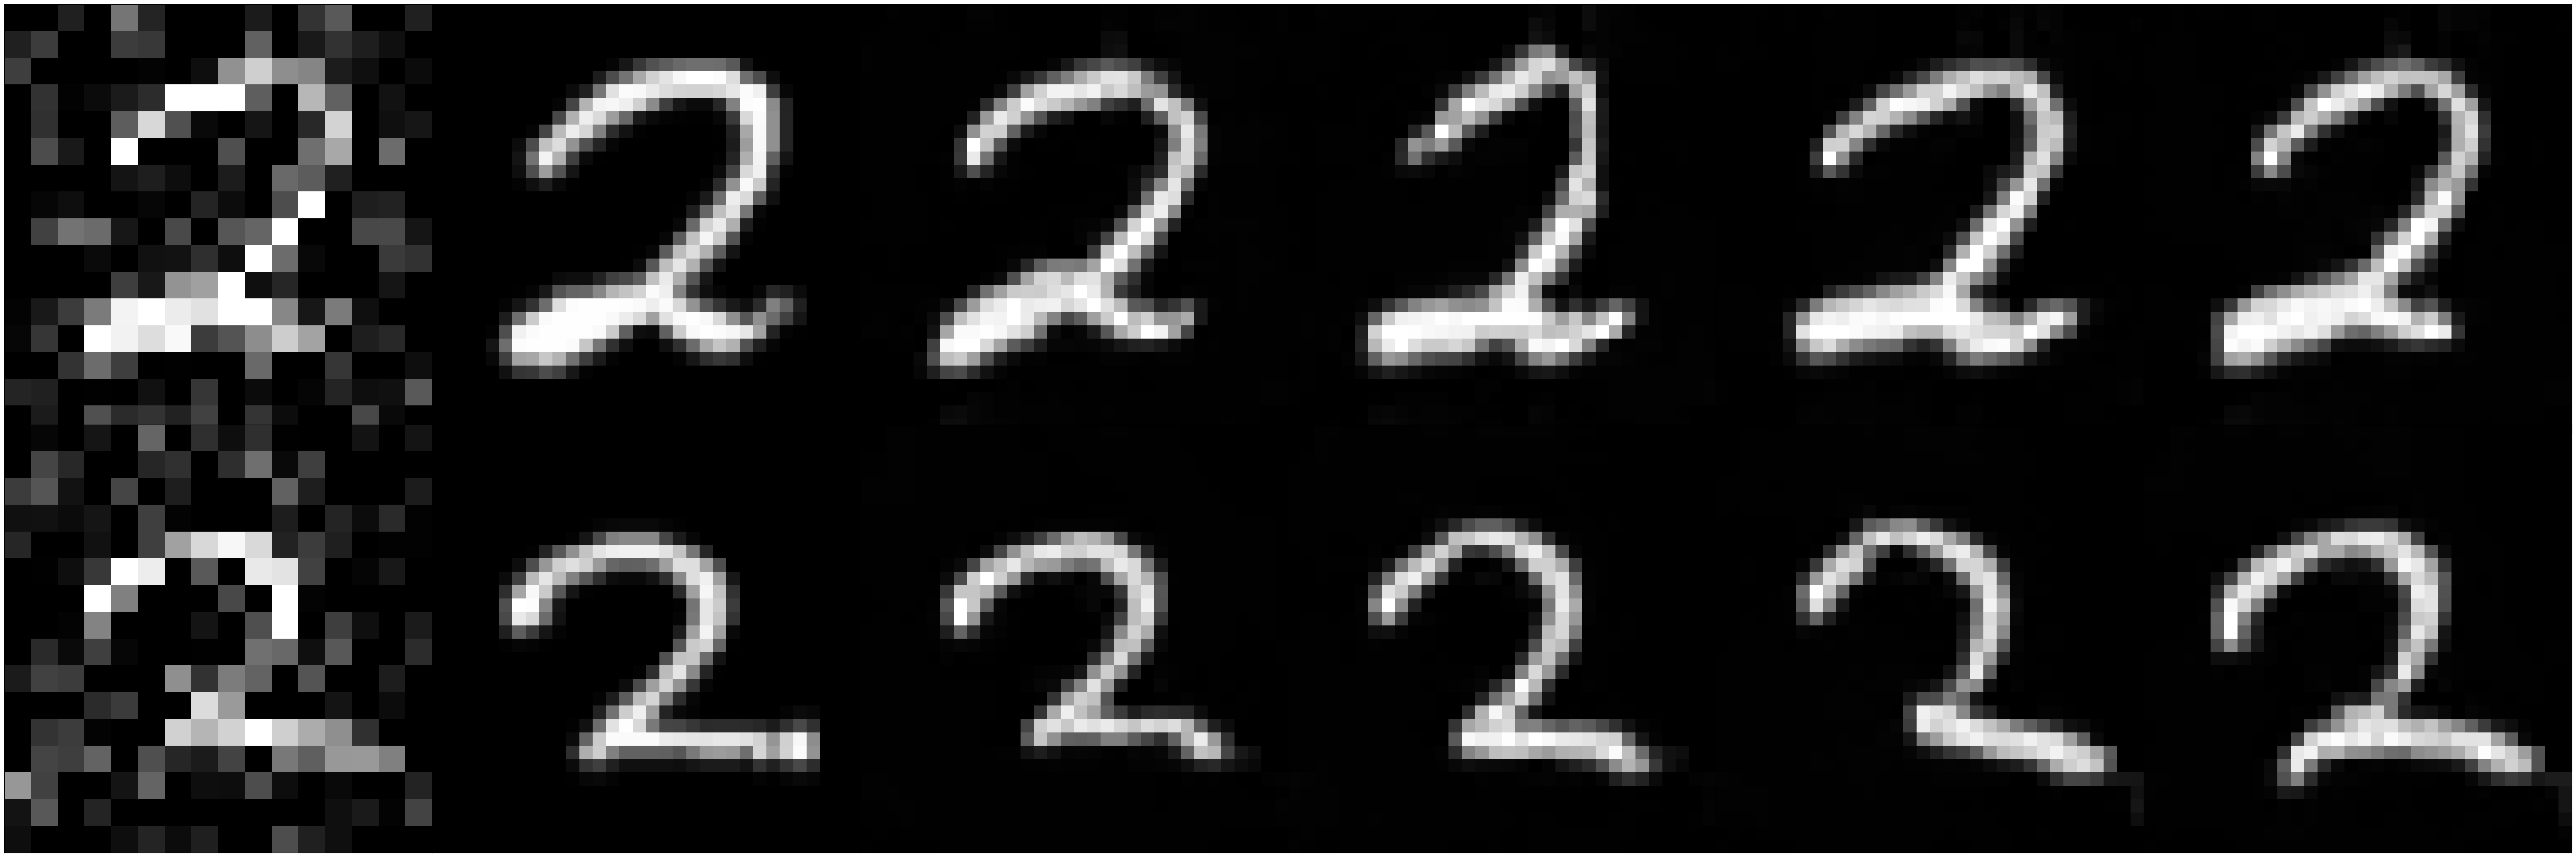

In [ ]:
## Plotting the results

fig, ax = plt.subplots(2, 6, figsize=(60, 20), dpi=100)

for idx,i in enumerate([1,6]):
    ax[idx, 0].imshow(X_test_fixed[i,0].mul(0.5).add(0.5).clip(0,1), cmap='gray')
    ax[idx, 0].set_xticks([]); ax[idx, 0].set_yticks([])
    ax[idx, 1].imshow(Y_test_fixed[i,0].mul(0.5).add(0.5).clip(0,1), cmap='gray')
    ax[idx, 1].set_xticks([]); ax[idx, 1].set_yticks([])
    ax[idx, 2].imshow(T_XZ_test_fixed[i, 0,0].mul(0.5).add(0.5).clip(0,1), cmap='gray')
    ax[idx, 2].set_xticks([]); ax[idx, 2].set_yticks([])
    ax[idx, 3].imshow(T_XZ_test_fixed[i, 1,0].mul(0.5).add(0.5).clip(0,1), cmap='gray')
    ax[idx, 3].set_xticks([]); ax[idx, 3].set_yticks([])
    ax[idx, 4].imshow(T_XZ_test_fixed[i, 2,0].mul(0.5).add(0.5).clip(0,1), cmap='gray')
    ax[idx, 4].set_xticks([]); ax[idx, 4].set_yticks([])
    ax[idx, 5].imshow(T_XZ_test_fixed[i, 3,0].mul(0.5).add(0.5).clip(0,1), cmap='gray')
    ax[idx, 5].set_xticks([]); ax[idx, 5].set_yticks([])
fig.tight_layout(pad=0)


fig.savefig('mnist2_sr_sq_0_reduced.pdf',bbox_inches='tight')

In [ ]:
## Computing PSNR and SSIM for the whole test set
from skimage.metrics import peak_signal_noise_ratio as psnr

all_psnr = []
psnr_mean = []

for X_test, Y_test in zip(mnist_2_test_dr_loader, mnist_2_test_loader):
    X_test, Y_test = X_test[0].to(DEVICE), Y_test[0].to(DEVICE)
    Z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 32, 32, device=DEVICE)
    XZ = torch.cat([X_test[:,None].repeat(1,Z_SIZE,1,1,1), Z], dim=2)
    with torch.no_grad():
        T_XZ = restore_z(T(hide_z(XZ)), BATCH_SIZE)
    
    for i in range(BATCH_SIZE):
        for j in range(Z_SIZE):
            all_psnr.append(psnr(Y_test[i].cpu().numpy(),T_XZ[i,j].cpu().numpy(), data_range=2))
        posterior_mean_estimate = T_XZ.mean(dim=1)
        psnr_mean.append(psnr(Y_test[i].cpu().numpy(),posterior_mean_estimate[i].cpu().numpy(), data_range=2))

In [ ]:
np.mean(all_psnr), np.mean(psnr_mean)

(20.895449394203794, 22.03153877301351)